# Introduction to Azure Machine Learning

This notebook will get you familiar with the basic concepts of the Azure Machine Learning (AML) service and how to interact with it using the Python SDK.

## 1. Import Azure ML Python Python SDK

We start by importing the core package and print its version number.

In [ ]:
import azureml.core
print('SDK version:', azureml.core.VERSION)

## 2. Authentication and initializing Azure Machine Learning Workspace

As a first step you have to authenticate against the Azure [Machine Learning Workspace](https://ml.azure.com/). This can be achieved in different ways:

1. **Interactive Login Authentication:** The interactive authentication is suitable for local experimentation on your own computer.
2. **Azure CLI Authentication:** Azure CLI authentication is suitable if you are already using Azure CLI for managing Azure resources, and want to sign in only once.
3. **Managed Service Identity (MSI) Authentication:** The MSI authentication is suitable for automated workflows, for example as part of Azure Devops build.
4. **Service Principal Authentication:** The Service Principal authentication is suitable for automated workflows, for example as part of Azure Devops build.

For now, we will use the interactive authentication, which is the default mode when using Azure ML SDK. When you connect to your workspace using `Workspace.from_config`, you might get an interactive login dialog, depending on if you are already logged in.

In [ ]:
from azureml.core import Workspace
ws = Workspace.from_config()

print("Workspace name: " + ws.name, 
      "Azure region: " + ws.location, 
      "Subscription id: " + ws.subscription_id, 
      "Resource group: " + ws.resource_group, sep='\n')

## 3. Create an experiment

An experiment is a logical container in an Azure ML Workspace. It contains a series of trials called `Runs`. As such, it hosts run records such as run metrics, logs, and other output artifacts from your experiments.

Let's create a first minimal experiment:

In [ ]:
from azureml.core import Experiment

experiment = Experiment(
    workspace=ws,
    name="introduction"
)

## 4. Starting a run

A run is always executed in the context of an experiment. In the easiest form, we can start a run as shown below:

In [ ]:
# start logging for the run
run_in_notebook = experiment.start_logging()

# access the run id for use later
run_in_notebook_id = run_in_notebook.id

# change the number on different runs to see how you can compare multiple runs
random_number = 2

# change the category on different runs to see how to organize data in reports
category = "Red"

Now we have a `run` object in status `Running` and can start using it to log metrics and other things.

Once a run is started you can see the run in the portal by simply typing ``run``.  Clicking on the "Link to Portal" link will take you to the Run Details page that shows the metrics you have logged and other run properties.  You can refresh this page after each logging statement to see the updated results.

In [ ]:
run_in_notebook

You can also view an experiement similarly by typing `experiment`.  The portal link will take you to the experiment's Run History page that shows all runs and allows you to analyze trends across multiple runs.

In [ ]:
experiment

## 5. Log metrics

Metrics are visible in the run details page in the AzureML portal and also can be analyzed in experiment reports.  The run details page looks as below and contains tabs for Details, Outputs, Logs, and Snapshot.  
* The Details page displays attributes about the run, plus logged metrics and images.  Metrics that are vectors appear as charts.  
* The Outputs page contains any files, such as models, you uploaded into the "outputs" directory from your run into storage.  If you place files in the "outputs" directory locally, the files are automatically uploaded on your behald when the run is completed.
* The Logs page allows you to view any log files created by your run.  Logging runs created in notebooks typically do not generate log files.
* The Snapshot page contains a snapshot of the directory specified in the ''start_logging'' statement, plus the notebook at the time of the ''start_logging'' call.  This snapshot and notebook can be downloaded from the Run Details page to continue or reproduce an experiment.

The following cell logs a string metric.  A string metric is simply a string value associated with a name. String metrics are useful for labelling runs and to organize your data.  Typically you should log all string parameters as metrics for later analysis - even information such as paths can help to understand how individual experiements perform differently.

String metrics can be used in the following ways:
* Plot in histograms
* Group by indicators for numerical plots
* Filtering runs

String metrics appear in the **Tracked Metrics** section of the Run Details page and can be added as a column in Run History reports.

In [ ]:
# log a string metric
run_in_notebook.log(name="Category", value=category)

Similary, we can log numerical metrics:

In [ ]:
# log numerical values
run_in_notebook.log(name="random number", value=random_number)
run_in_notebook.log(name="Magic Number", value=42*random_number)

Now let's do some calcuations and log their results. We use the fibonacci series as an example here.

In [ ]:
from tqdm import tqdm
import numpy as np

scale_factor = 2
fibonacci_values = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
scaled_values = (i * scale_factor for i in fibonacci_values)

# Log a list of values. Note this will generate a single-variable line chart.
run_in_notebook.log_list(name="Fibonacci", value=scaled_values)

for i in tqdm(range(-10, 10)):
    # log a metric value repeatedly, this will generate a single-variable line chart.
    run_in_notebook.log(name="Sigmoid", value=1 / (1 + np.exp(-i)))

Go to the run in the AzureML portal (using the link from above) and explore the metrics that you have just logged. It should look similar to this:
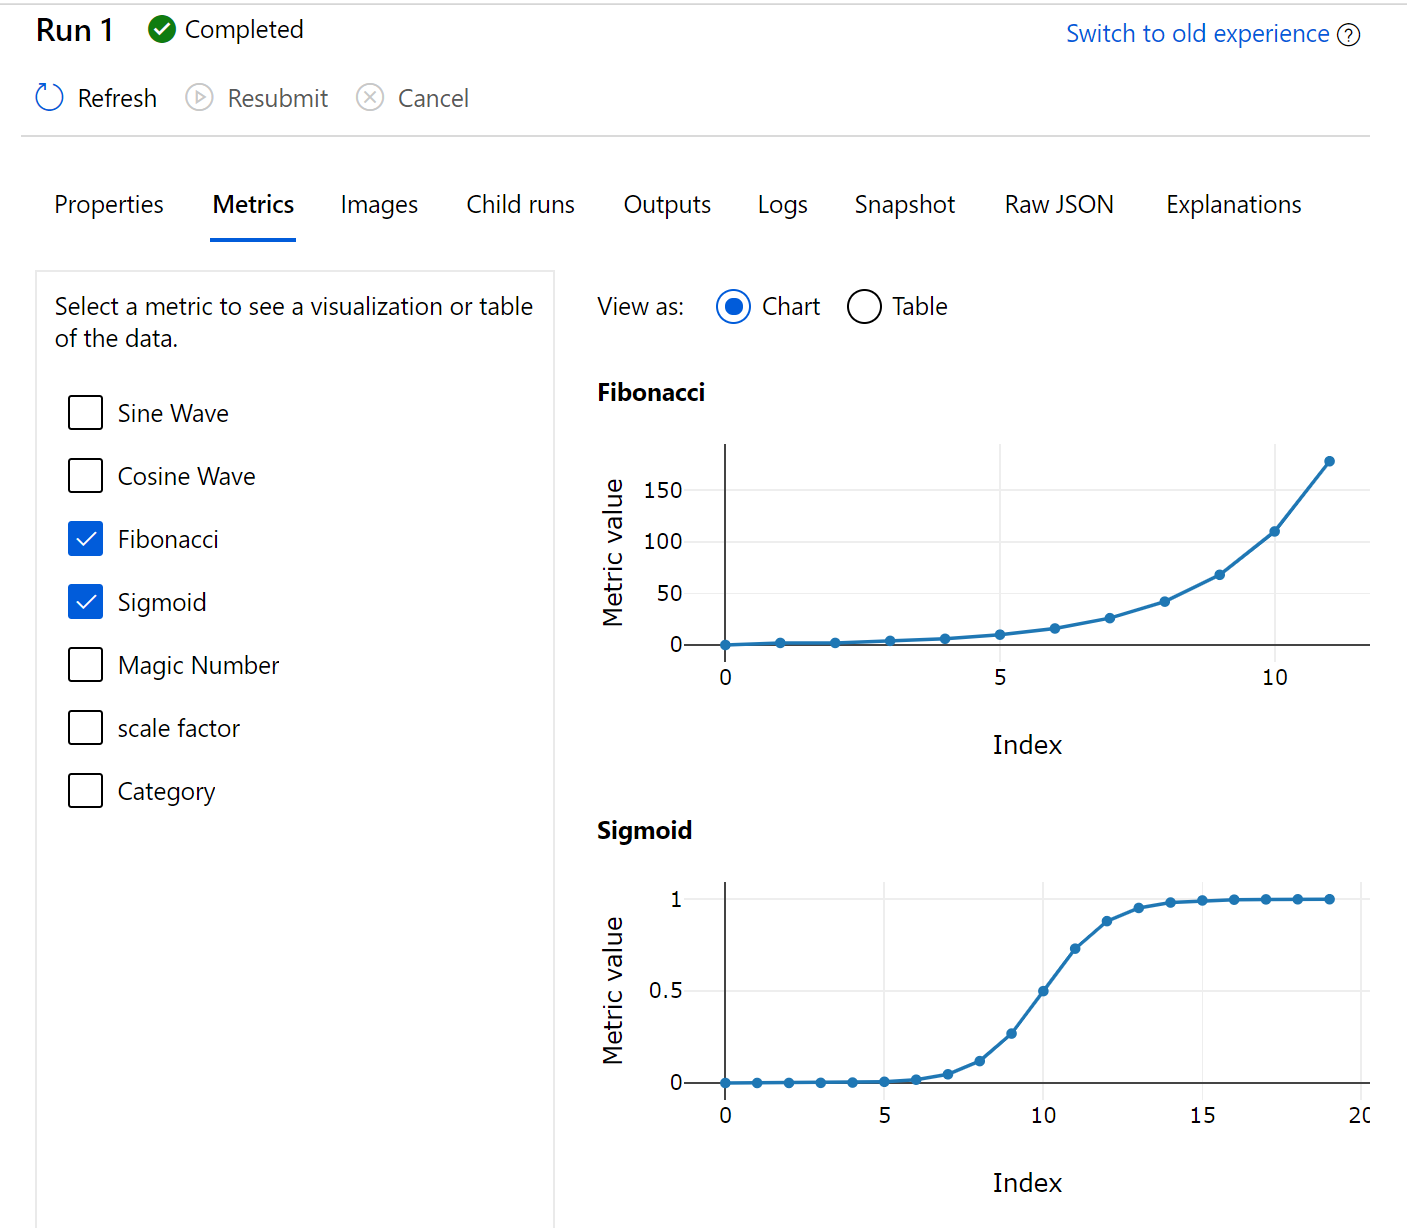

And some more calculations to generate more metrics:

In [ ]:
# create a dictionary to hold a table of values
sines = {}
sines["angle"] = []
sines["sine"] = []

for i in tqdm(range(-10, 10)):
    angle = i / 2.0 * random_number
    
    # log a 2 (or more) values as a metric repeatedly. This will generate a 2-variable line chart if you have 2 numerical columns.
    run_in_notebook.log_row(name="Cosine Wave", angle=angle, cos=np.cos(angle))
    
    sines["angle"].append(angle)
    sines["sine"].append(np.sin(angle))

# log a dictionary as a table, this will generate a 2-variable chart if you have 2 numerical columns
run_in_notebook.log_table(name="Sine Wave", value=sines)

Again, explore how the metrics appear in your run UI.

Apart from logging strings or numerical values to a run, we can also upload any files that we want to associate with it.
This could for example to additional log files. In most machine learning scenarios, you at least want to upload your trained model file here.

*Note*: Input data is usually not to be uploaded to a log, as there are different mechanism to track those. We will learn about those later when we talk about *Datastores*.

In [ ]:
file_name = "outputs/myfile.txt"

with open(file_name, "w") as f:
    f.write("This is an output file that will be uploaded.\n")

# Upload the file explicitly into artifacts 
run_in_notebook.upload_file(name=file_name, path_or_stream=file_name)

## 6. Complete the run

Calling `run.complete()` marks the run as completed and triggers the output file collection.  If for any reason you need to indicate the run failed or simply need to cancel the run you can call `run.fail()` or `run.cancel()`.

In [ ]:
run_in_notebook.complete()

## 7. Run a project locally in docker environment

The above way to start a run and log metrics to it, is the easiest one. You could for example use it, when executing a machine learning training directly on your local laptop in an interactive jupyter notebook.
However, this is often not how you would run experiments - especially when it comes to scaling them. For this, AzureML provides an easy way to package a training into a docker container.

As the container has all the dependencies packaged up, it makes it easy to run your training anywhere - not just on your local development machine.

In [ ]:
TRAIN_FOLDER_NAME = "train"
TRAIN_FILE_NAME = "train.py"

In [ ]:
import os
os.makedirs(name=os.path.join(".", TRAIN_FOLDER_NAME), exist_ok=True)

Instead of running the training steps cell-by-cell, as we did above when running an experiment in an interactive session, we need to put them into one script. This is typically called something like `train.py`.

*Note:* `%%writefile` is a so-called Jupyter Magic. It is used to create a new file on disk within the working folder of this notebook. The python code below the magic is NOT executed when you run the cell. Instead, the code as written as a text file to the path specified by `$TRAIN_FOLDER_NAME/$TRAIN_FILE_NAME`. See [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile) for more information on the use of Magics. Other Magics for example enable you to run shell commands on the command line directly from a cell (`%%sh`).

Since the python code is not evaluated in this case, but only later in the actual run execution, you will not see any immediate errors, e.g. for syntax mistakes. Hence, be extra careful when writing your code here since you will only see errors in the actual execution. This can make debugging more time-consuming.

In [ ]:
%%writefile $TRAIN_FOLDER_NAME/$TRAIN_FILE_NAME

from azureml.core import Run

# Retrieve the run object
run = Run.get_context()

run.log(name="message", value="Hello from run!")
print("Hello World!")

As you can see, we do not explicitly need to start the run as we did above. When executing it using AzureML, a run instance will be injected into your script and you can retrieve it from the context and then use it like before.

To execute a run using our training script, we use an `Estimator`. There are generic estimators as we use below. But there are also specific ones which are pre-configured to use with certain ML frameworks such as sklearn or pyTorch.

Apart from specifying the directory and name of our training script, we also need to specify a compute target. AzureML provides various ways to run experiments. We will use one of the so called Managed Compute options later. For now we select to run the dockerized training on our local machine. Note that you need to have Docker up and running on the machine in order for this to work.

In [ ]:
from azureml.train.estimator import Estimator

estimator = Estimator(
    source_directory=TRAIN_FOLDER_NAME,
    entry_script=TRAIN_FILE_NAME,
    compute_target="local"
)

Now we are ready to submit our experiment with the configuration that we set above. 
You can follow the output here in the notebook or also look at the run in the portal UI as before.

You will note that one of the first steps is to pull the docker base images and build the training container based on it.
As our "training" script does not really do any training here, the setup process takes much longer than the following execution itself.

In [ ]:
run_in_docker = experiment.submit(
    config=estimator,
    tags={}
)
run_in_docker

In [ ]:
run_in_docker.wait_for_completion(
    show_output=True,
    wait_post_processing=True
)

## 8. Analyze results

You can refresh the run in the Azure portal to see all of your results.  In many cases you will want to analyze runs that were performed previously to inspect the contents or compare results.  Runs can be fetched from their parent Experiment object using the ``Run()`` constructor or the ``experiment.get_runs()`` method. 

In [ ]:
from azureml.core import Run

fetched_run = Run(
    experiment=experiment,
    run_id=run_in_notebook_id)
fetched_run

Call ``run.get_metrics()`` to retrieve all the metrics from a run.

In [ ]:
fetched_run.get_metrics()

See the files uploaded for this run by calling ``run.get_file_names()``

In [ ]:
fetched_run.get_file_names()

Once you know the file names in a run, you can download the files using the ``run.download_file()`` method

In [ ]:
import os
os.makedirs("files", exist_ok=True)

for f in fetched_run.get_file_names():
    dest = os.path.join("files", f.split("/")[-1])
    print(f"Downloading file {f} to {dest}...")
    fetched_run.download_file(f, dest)

Check the text in the downloaded file with a magic command.

In [ ]:
%pycat files/myfile.txt

Often when you analyze the results of a run, you may need to tag that run with important personal or external information.  You can add a tag to a run using the ``run.tag()`` method.  AzureML supports valueless and valued tags.

In [ ]:
fetched_run.tag("My Favorite Run")
fetched_run.tag("Competition Rank", "1")
fetched_run.get_tags()

## 9. Summary

This concludes our first overview of the AzureML service and its Python SDK usage. You have learned about the basic concepts of a `Workspace`, `Experiments`, `Runs` and how to execute them interactively as well as in a dockerized environment.
We have logged various metrics and associated files with a run and have seen how those can be visualized and retrieve in the AzureML portal UI.

Now you are equipped to dive into more details and run actual machine learning trainings.

## 10. Bonus

In case you still have time left, here are a few more optional things you can try to implement in the notebook above:

- Start a new run of the in-notebook-experiement and this time, instead of finishing the run successfully, mark a run as failed or as cancelled.
- When you create the Estimator object for the dockerized execution, you can optionally specify additional pip or Conda packages to be installed. Find out how to do this, add one or two simple packages and observe how the logging output changes when you submit that run. See [here](https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.estimator.estimator?view=experimental) for hints how to do that.